In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random


from SPINN import ModifiedMLP, RandomFourierEncoding
#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)

class rPINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[8,8,8,8]):
        super().__init__()

        # Predicts r
        #self.nn = NNBlock(in_chan, out_chan, chans=chans)
        self.nn = nn.Sequential(
            RandomFourierEncoding(in_chan, chans[0]//2),
            ModifiedMLP(chans[0], out_chan, chans)
        )
        


        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)))
        self.p_ = torch.nn.Parameter(torch.abs(torch.randn(1)))



        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.M_.requires_grad = True
        self.p_.requires_grad = True

    def forward(self, x):
        return self.nn(x)
    
    def get_e(self):
        #return torch.abs(self.e_)
        return torch.tanh(torch.abs(self.e_))
    
    def get_M(self):
        return torch.abs(self.M_)
    
    def get_p(self):
        return torch.abs(self.p_)

    def physical_loss(self, phi):
        r = self.forward(phi)

        p  = self.get_p()
        M  = self.get_M()
        e  = self.get_e()

        dr = grad(r, phi)[0]
        ddr = grad(dr, phi)[0]

        ode1 = dr**2 - 2*M*r**4 * (1/r - (1-e)/p) * (1/r - (1+e)/p) * (1/r - 1/(2*M) + 2/p)

        A = (4*e**2*M - p)*r/p
        B = 3*(p - M*(3+2*e**2 - e**4))*(r/p)**2 * (1-e**2)
        C = 2*(4*M - p) * (r/p)**3 * (1-e**2)**3
        ode2 = ddr - (M + A + B + C)

        #ode = dr**2 - 2*M*r**4*(1/r - (1 + e)/p)*(1/r - (1-e)/p)*(1/r - 1/(2*M) + 2/(p*(1-e**2)))
        #ode = dr - r**2*torch.sqrt(2*M*(1/r - (1 + e)/p)*(1/r - (1-e)/p)*(1/r - 1/(2*M) + 2/(p*(1-e**2))))
        #ode = dr**2 - ((r*(p + (e-1)*r)*(-p + r + e*r)*(-2*(-1 + e**2)*M*p + 4*M*r + (-1 + e**2)*p*r))/((-1 + e**2)*p**3)).abs_()

        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        return loss1 + loss2

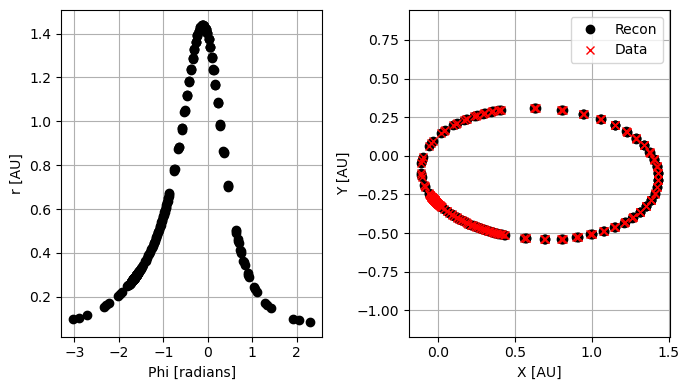

In [31]:
micro_arcsec_to_au = torch.pi / (3600*180) * 8 * 1000 * 206265 * 1e-3 # to units 1e-2 AU

data = pd.read_csv("data/simulated_data.csv")
y = torch.tensor(data.iloc[:,1], dtype=torch.float32) * micro_arcsec_to_au
x = torch.tensor(data.iloc[:,2], dtype=torch.float32) * micro_arcsec_to_au

#phi = np.arctan(y/x).unsqueeze(1)
#u = (1/np.sqrt(x**2 + y**2))
r = np.sqrt(x**2 + y**2)

phi = np.arccos(x/r) 
phi = torch.where(y<0., -phi, phi).float()
#phi = torch.where(phi<0, phi+2*torch.pi, phi)
#phi = torch.where(phi>2.2*torch.pi, phi-2*torch.pi, phi)


r = r.unsqueeze(1)
phi = phi.unsqueeze(1)

fig, ax = plt.subplots(figsize=(7,4), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, r, 'ko')
ax[0].set_ylabel("r [AU]")
ax[0].set_xlabel("Phi [radians]")

ax[1].plot(np.cos(phi[:,0])*r[:,0], np.sin(phi[:,0])*r[:,0], 'ko', label="Recon")
ax[1].plot(x, y, 'rx', label="Data")
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")
ax[1].legend()

ax[1].axis('equal')

[axi.grid() for axi in ax]

plt.tight_layout()


In [32]:
# Initialize model
lr = 1e-3

#model = PINN(1, 1, chans=[8,16,32,16,8]).to(device)
model = rPINN(1, 1, chans=[32]*4).to(device)

#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.0)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
#                patience=200, threshold=0.0001, verbose=True, cooldown=200)


losses = [[], []]
params = [[], [], []]

#phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
N = 2.  # How many pi do I want to extend the angles with, when evaluating the physics
phi_lin = torch.linspace(phi.min() - torch.pi*N, phi.max() + torch.pi*N, steps=1024).view(-1,1).requires_grad_(True)

phys_loss_weight = 1. #1e-4
#phys_loss_weight = 1e4

batch_size = 128
batch_size_phys = 128


epoch_start = 20 # temporary parameter to set when physics loss is activated (and ...)

epoch = 0

In [33]:
epochs = 10_000

for i in tqdm(range(epochs)):
    epoch += 1
    ind = torch.tensor(random.sample(range(len(phi)), batch_size))
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    phi_ = phi[ind]
    #if epoch < epoch_start:
    phi_ = (phi_ + (torch.randint(low=0,high=3,size=phi_.shape) - 1) * 2 * torch.pi)
    
    r_ = r[ind]
    phi_lin_ = phi_lin[ind_p]

    phi_ = phi_.to(device)
    r_ = r_.to(device)
    phi_lin_ = phi_lin_.to(device)
    
    out = model(phi_)

    MSEloss = criterion(out, r_)
    #MSEloss = criterion(torch.log(out), torch.log(u_))
    #MSEloss = criterion(1/out, 1/u_)    # Minimize difference in r
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))    # Minimize relative difference
    #MSEloss = torch.mean(torch.abs(out - u)**2 / (torch.abs(u) + 1e-8))    # Minimize MSE weightet by r

    #phi_lin = (torch.randn(1000, 1, requires_grad=True) * 10).to(device)
    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin_)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    losses[0].append(MSEloss.item())
    losses[1].append(PHYSloss.item())

    #loss = MSEloss + PHYSloss

    if epoch > epoch_start:
        loss = MSEloss + PHYSloss
    else:
        loss = MSEloss

    # Decrease the physics loss weight over time
    #if epoch < epoch_start:
    #    phys_loss_weight *= 0.99  # Decay factor
    #    loss = MSEloss + phys_loss_weight * PHYSloss
    #else:
    #    loss = MSEloss

    optimizer.zero_grad()
    loss.backward()
    #if epoch % 2 == 0:
    #    MSEloss.backward()
    #else:
    #    PHYSloss.backward()
    optimizer.step()
    #scheduler.step(torch.log10(loss))

    params[0].append(model.get_e().item())
    params[1].append(model.get_p().item())
    params[2].append(model.get_M().item())


100%|██████████| 10000/10000 [03:31<00:00, 47.18it/s]


1.0
tensor(0.0055, grad_fn=<MeanBackward0>)


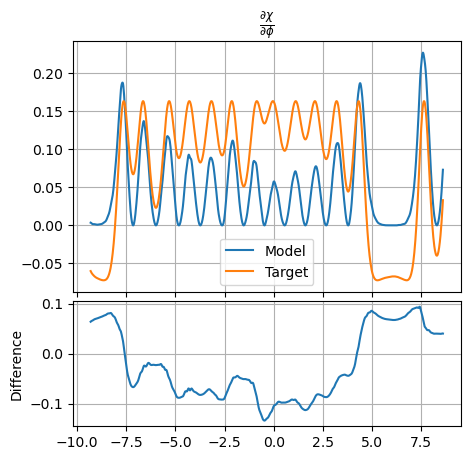

In [34]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = phi_lin # torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True)

_r = model.nn(_phi)
p = model.get_p().item()
M = model.get_M().item()
e = model.get_e().item()

dr = grad(_r, _phi)[0]
ode = dr**2 - 2*M*_r**4*(1/_r - (1 + e)/p)*(1/_r - (1-e)/p)*(1/_r - 1/(2*M) + 2/(p*(1-e**2)))

print(phys_loss_weight)
print(torch.mean(ode**2))

ode = ode.detach().numpy()

_phi = _phi.detach().numpy()
dr = dr.detach().numpy()
_r = _r.detach()

fig, ax = plt.subplots(nrows=2, figsize=(5,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0].grid()
ax[0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0].plot(_phi, dr**2, label="Model")
ax[0].plot(_phi, 2*M*_r**4*(1/_r - (1 + e)/p)*(1/_r - (1-e)/p)*(1/_r - 1/(2*M) + 2/(p*(1-e**2))), label="Target")
ax[0].legend()

ax[1].grid()
ax[1].set_ylabel("Difference")
ax[1].plot(_phi, ode)

plt.subplots_adjust(hspace=.05)

e = 0.1846945434808731
p = 0.37727978825569153
M = 0.8766882419586182
M-model-data = 0.5534774661064148


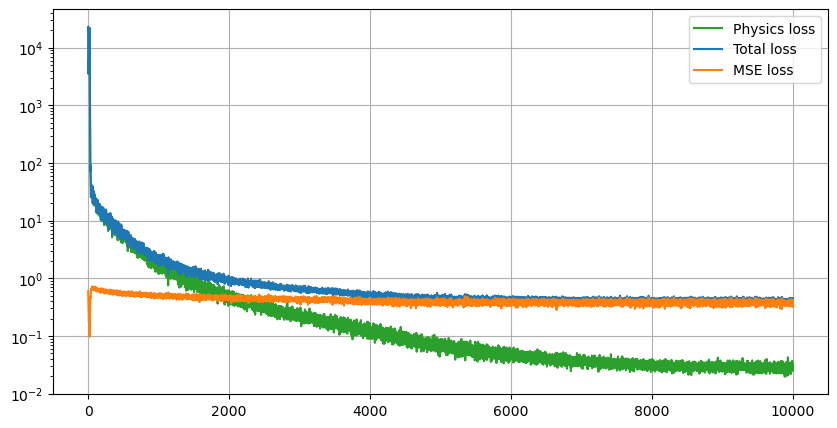

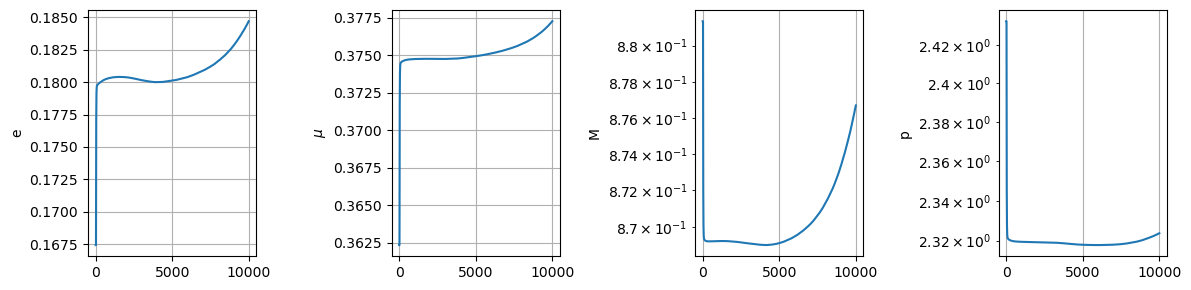

In [35]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())


M_md = torch.mean(1 - torch.abs(model(phi.to(device)).cpu() - r)/r).item()
print("M-model-data =", M_md)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses[1], label="Physics loss", c="tab:green")
ax.plot(np.array(losses[0]) + np.array(losses[1]), label="Total loss", c="tab:blue")
ax.plot(losses[0], label="MSE loss", c="tab:orange")

ax.grid()
ax.legend()
ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=4, figsize=(12,3))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
ax[1].set_ylabel(r"$\mu$")
#ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()
ax[2].set_yscale("log")

ax[3].plot(np.array(params[2])/np.array(params[1]))
ax[3].set_ylabel("p")
ax[3].grid()
ax[3].set_yscale("log")


plt.tight_layout()
plt.show()

# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

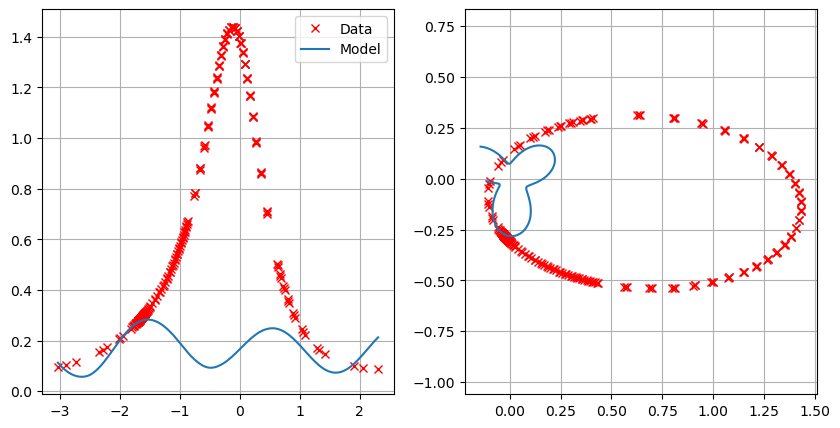

In [36]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
ax[0].plot(phi, r, 'rx', label="Data")


theta = torch.linspace(phi.min(), phi.max(), steps=1000, dtype=torch.float32).to(device)
r_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, r_, label="Model")
#ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
#ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(phi[:,0])*r[:,0], torch.sin(phi[:,0])*r[:,0], "rx")


theta = theta.numpy()
ax[1].plot(r_*np.cos(theta), r_*np.sin(theta));


# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU
#u_test = 1/228 * (1 + 0.884*torch.cos(model.nn(torch.tensor(theta).unsqueeze(1)))).detach().numpy()[:,0]
#ax[0].plot(theta, u_test, label="Target?")
#ax[1].plot(np.cos(theta)/u_test, np.sin(theta)/u_test)


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend();
#ax.set_xscale("log")
#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)v

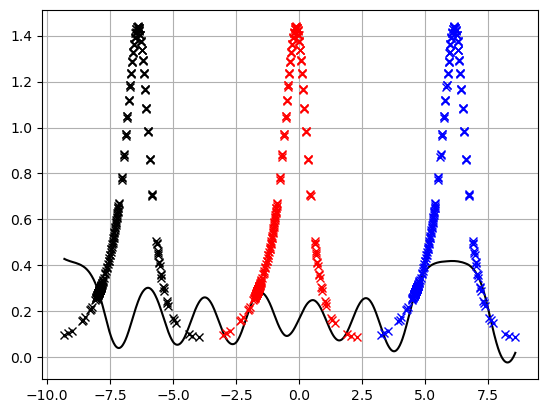

In [37]:
fig, ax = plt.subplots()
ax.grid()

r_lin = model(phi_lin).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], r_lin, 'k')


ax.plot(phi.cpu(), r.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), r.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), r.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


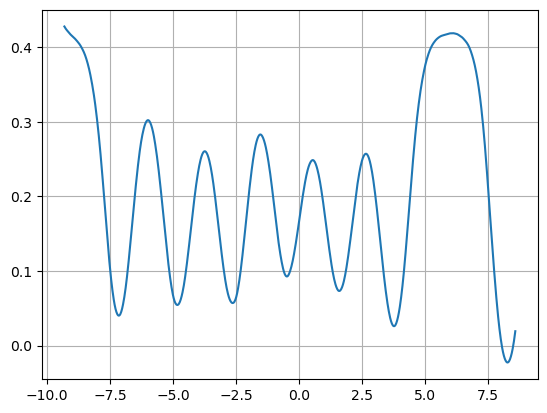

In [38]:
x = phi_lin
y = model.nn(x)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [39]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'S-STAR-PINN.pth')